In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ompy as om
import logging
import pandas as pd
import json

import scipy as sp
#%matplotlib widget
from ipywidgets import widgets #interact, interactive, fixed, interact_manual

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


In [2]:
om.__full_version__;
np.random.seed(1382398)


In [3]:
from ipynb.fs.full.functions import *



In [4]:
#setting figsize
plt.rcParams["figure.figsize"] = (8,6)

plt.rcParams["figure.autolayout"] = True

#size of marker and errorbar caps
plt.rcParams["errorbar.capsize"] = 5
plt.rcParams["lines.markersize"] = 5

#setting label sizes
plt.rcParams['font.size'] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 16


#set linewidths and markersize
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['lines.markersize'] = 5

#set x and y axis
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.minor.size'] = 1.5
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.top'] = True

plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.minor.size'] = 1.5
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['legend.frameon'] = False

#setting different dpi for notebook and saving
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["figure.dpi"] = 80

Import $\gamma$SF and NLD from Oslo Method Software

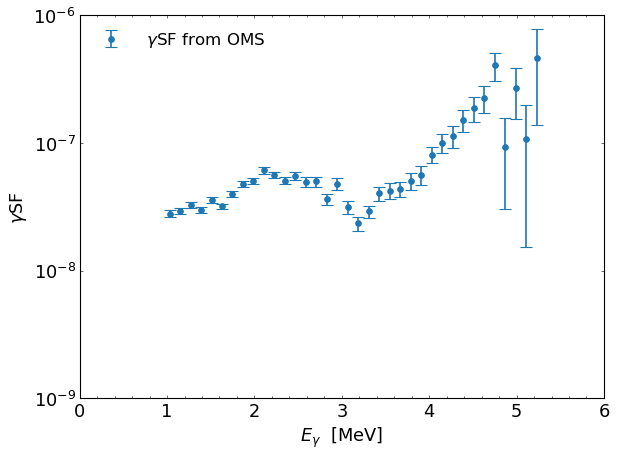

In [5]:
#reading files
def read_OMS(OMS_path):
    #OMS = Oslo Method Software
    #My normalization
    strength_nrm = np.genfromtxt(OMS_path+"strength.nrm") #experimental gamma strength function
    discrete_levels = np.genfromtxt(OMS_path+"rholev.cnt") #Discrete levels 
    rhopaw = np.genfromtxt(OMS_path+"rhopaw.cnt") #experimental level density
    fermigas = np.genfromtxt(OMS_path+"fermigas.cnt") #fermi gas extrapolation of nld
    trans_raw = np.genfromtxt(OMS_path+"transext.nrm") #gsf extrapolation
    fg_theo_file = OMS_path+'fgteo.rsg'
    fg_exp_file = OMS_path+'fg.rsg'
    fg_exp_err_file = OMS_path+'fgerr.rsg'
    
    #reading calibration constants from strength.cpp
    infile = open(OMS_path+'strength.cpp', 'r')
    for line in infile:
        values = line.split()
        if len(values)>1 and values[1]=='a0':
            a0 = float(values[3][:-1])
        if len(values)>1 and values[1]=='a1':
            a1 = float(values[3][:-1])
            break
    
    #splitting arrays into data and errors
    strength_nrm_split = np.array_split(strength_nrm,2)
    gsf_OMS = strength_nrm_split[0] 
    gsf_OMS_error = strength_nrm_split[1]

    rhopaw_split = np.array_split(rhopaw, 2)
    nld_OMS = rhopaw_split[0]
    nld_OMS_error = rhopaw_split[1]

    #variables for this experiment
    Sn = 5.762
    rhoSn = 28.07e6
    rhoSn_error = 7.02e6
    Eg_min = 999.9
    Eg_max = 5252

    #making energy array for gsf
    n_gsf = len(gsf_OMS)
    energy_gsf_OMS = np.zeros(n_gsf)
    for i in range(n_gsf):
        energy_gsf_OMS[i] = a0 + a1*i

    #making energy array for nld
    n_fermi = len(fermigas)
    energy_nld_OMS = np.zeros(n_fermi)
    for i in range(n_fermi):
        energy_nld_OMS[i] = a0 + a1*i

    #finding cutting index for plotting CT extrapolation
    n0_CT = np.argmin(abs(energy_nld_OMS-3.0))
    n1_CT = np.argmin(abs(energy_nld_OMS-Sn-0.5))

    n_trans_raw=len(trans_raw)
    gsf_extrapolation=np.zeros(n_trans_raw)
    energy_gsf_extrapolation=np.zeros(n_trans_raw)
    for i in range(n_trans_raw):
        energy_gsf_extrapolation[i] = a0 + a1*i
        gsf_extrapolation[i] = trans_raw[i]/(2*3.14*energy_gsf_extrapolation[i]**3)


    gsf_values = [energy_gsf_OMS, gsf_OMS, gsf_OMS_error]
    nld_values = [energy_nld_OMS, nld_OMS, nld_OMS_error, discrete_levels, fermigas, rhoSn, rhoSn_error, Sn, n0_CT, n1_CT]
    return gsf_values, nld_values

gsf_values = read_OMS('analysis/OMS/120keVperBin/')[0]

energy_gsf_OMS = gsf_values[0]
gsf_OMS = gsf_values[1]
gsf_OMS_error = gsf_values[2]

fig, ax = plt.subplots()

#OMS-analysis
ax.errorbar(x=energy_gsf_OMS, y=gsf_OMS, yerr=gsf_OMS_error, marker='o', linestyle='', label=' $\gamma$SF from OMS')
ax.set_ylim(1e-9, 1e-6)
ax.set_xlim(0, 6)
ax.set_yscale('log')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel('$E_\gamma$  [MeV]')
ax.set_ylabel('$\gamma$SF')
ax.legend(fontsize=15)

fig.show()


In [6]:
#datetimes = ['02-04_17:11:09', '02-04_22:42:51', '02-04_15:39:51', '02-08_09:57:20']
#datetimes = ['02-22_17:36:16', '02-23_10:02:57', '02-23_13:03:23']
#datetimes = ['02-23_13:03:23', '02-23_14:08:46', '02-23_14:54:21']
#datetimes = ['02-23_13:03:23', '02-23_14:08:46', '02-26_15:59:51']
#datetimes = ['02-23_13:03:23', '02-23_14:08:46']
datetimes = ['03-01_11:35:59', '03-01_13:07:47']
#OMS_paths = ['analysis/OMS/120keVperBin/', 'analysis/OMS/180keVperBin/', 'analysis/OMS/240keVperBin/']
OMS_paths = ['analysis/OMS/120keVperBin/', 'analysis/OMS/180keVperBin/']
#OMS_paths = ['analysis/OMS/04_FEB/', 'analysis/OMS/04_FEB/', 'analysis/OMS/04_FEB/']

Import $\gamma$SF and NLD from OMPy

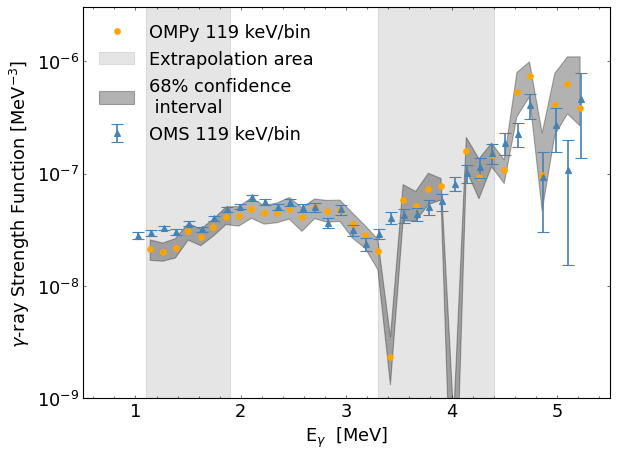

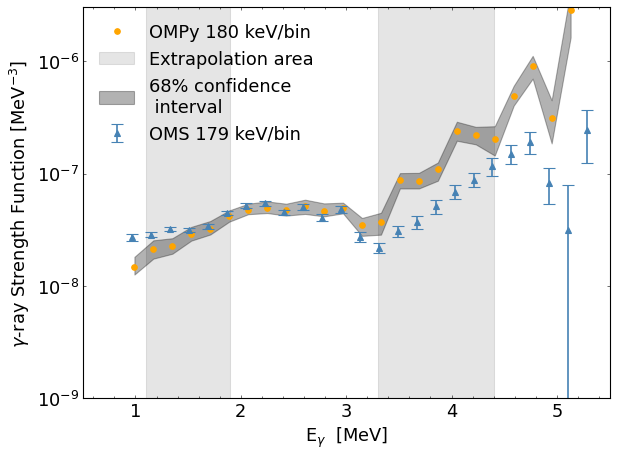

In [7]:
def plot_gsf_OMPy_vs_OMS(datetime, OMS_path, ax_gsf):
    #normalization areas for gsf
    gsfnorm_high = [3.3, 4.4]
    gsfnorm_low = [1.1, 1.9]
    
    ax_gsf.fill_between(gsfnorm_low, [1,1], [0,0], color='black', alpha=0.1, label='Extrapolation area')
    ax_gsf.fill_between(gsfnorm_high, [1,1], [0,0], color='black', alpha=0.1)
    
    [energy_gsf_OMS, gsf_OMS, gsf_OMS_error] = read_OMS(OMS_path)[0]
    [energy, median, error_upper, error_lower, error] = read_OMPy(datetime)[0]
    
    #make confidence interval plot
    ax_gsf.fill_between(energy, error_lower, error_upper, color='black', alpha=0.3, label='68% confidence\n interval')
    ax_gsf.plot(energy, median, marker='o', linestyle='',  color='orange', label='OMPy %.0i keV/bin'%check_kevperbin(energy))
    
    
    #plot settings
    ax_gsf.errorbar(x=energy_gsf_OMS, y=gsf_OMS, yerr=gsf_OMS_error, 
                marker='^', linestyle='', label='OMS %.0i keV/bin'%check_kevperbin(energy_gsf_OMS), color='steelblue')
    
    ax_gsf.set_ylim(1e-9, 3e-6)
    ax_gsf.set_xlim(0.5, 5.5)
    ax_gsf.set_yscale('log')
    ax_gsf.yaxis.set_minor_locator(AutoMinorLocator())
    ax_gsf.xaxis.set_minor_locator(AutoMinorLocator())
    ax_gsf.set_xlabel('E$_\gamma$  [MeV]')
    ax_gsf.set_ylabel('$\gamma$-ray Strength Function [MeV$^{-3}$]')
    ax_gsf.legend()
    
    
for i in range(len(datetimes)):
    datetime = datetimes[i]
    OMS_path = OMS_paths[i]
    fig, ax = plt.subplots()
    plot_gsf_OMPy_vs_OMS(datetime, OMS_path,ax)



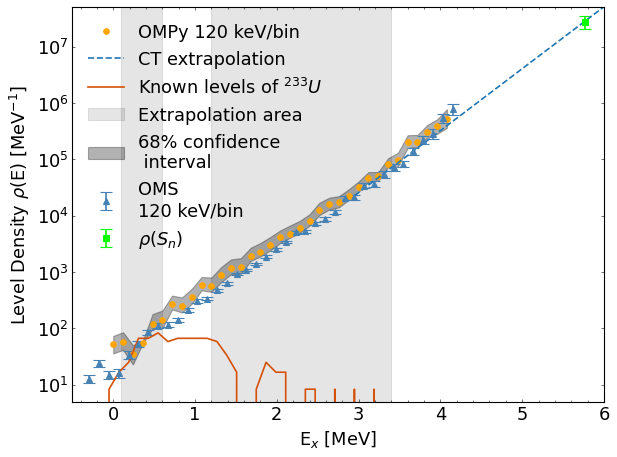

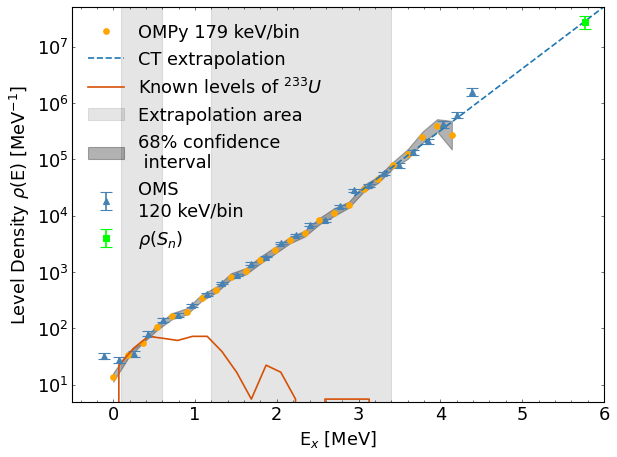

In [8]:
def plot_nld_OMPy_vs_OMS(datetime, OMS_path, ax_nld):
    
    #normalization areas for nld
    nldnorm_low = [0.1, 0.6]
    nldnorm_high = [1.2,3.4]
    
    ax_nld.fill_between(nldnorm_low, [1e8,1e8], [0,0], color='black', alpha=0.1, label='Extrapolation area')
    ax_nld.fill_between(nldnorm_high, [1e8,1e8], [0,0], color='black', alpha=0.1)
    
    [energy_nld_OMS, nld_OMS, nld_OMS_error, discrete_levels, fermigas, rhoSn, rhoSn_error, Sn, n0_CT, n1_CT] = read_OMS(OMS_path)[1]
    [energy, median, error_upper, error_lower, error] = read_OMPy(datetime)[1]
    
    #plotting OMS nld
    ax_nld.errorbar(x=energy_nld_OMS[:len(nld_OMS)], y=nld_OMS, yerr=nld_OMS_error, 
                marker='^', linestyle='', label='OMS\n%.0i keV/bin'%check_kevperbin(energy_gsf_OMS), color='steelblue')
        
    #plotting neutron separation energy
    ax_nld.errorbar(x=Sn, y=rhoSn, yerr=rhoSn_error, marker='s', linestyle='', label='$\\rho(S_n)$', color='lime')

    #plotting OMPy nld
    ax_nld.fill_between(energy, error_upper, error_lower, color='black', alpha=0.3, label='68% confidence\n interval')
    ax_nld.plot(energy, median, marker='o', linestyle='', color='orange', label = 'OMPy %.0i keV/bin'%check_kevperbin(energy))

    
    #plotting CT extrapolation from OMS
    ax_nld.plot(energy_nld_OMS[n0_CT:n1_CT], fermigas[n0_CT:n1_CT], linestyle='--', label='CT extrapolation')

    #plotting discrete levels
    ax_nld.plot(energy_nld_OMS[:len(discrete_levels)], discrete_levels, color="#D65108", label='Known levels of $^{233}U$')

    
    #NLD axis settings
    ax_nld.set_xlabel('E$_x$ [MeV]')
    ax_nld.set_ylabel('Level Density $\\rho$(E) [MeV$^{-1}$]')
    ax_nld.legend()
    ax_nld.set_yscale('log')
    ax_nld.yaxis.set_minor_locator(AutoMinorLocator())
    ax_nld.xaxis.set_minor_locator(AutoMinorLocator())
    ax_nld.set_ylim(5e0, 5e7)
    ax_nld.set_xlim(-.5, 6)
    

    
for i in range(len(datetimes)):
    datetime = datetimes[i]
    OMS_path = OMS_paths[i]
    fig, ax = plt.subplots()
    plot_nld_OMPy_vs_OMS(datetime, OMS_path,ax)


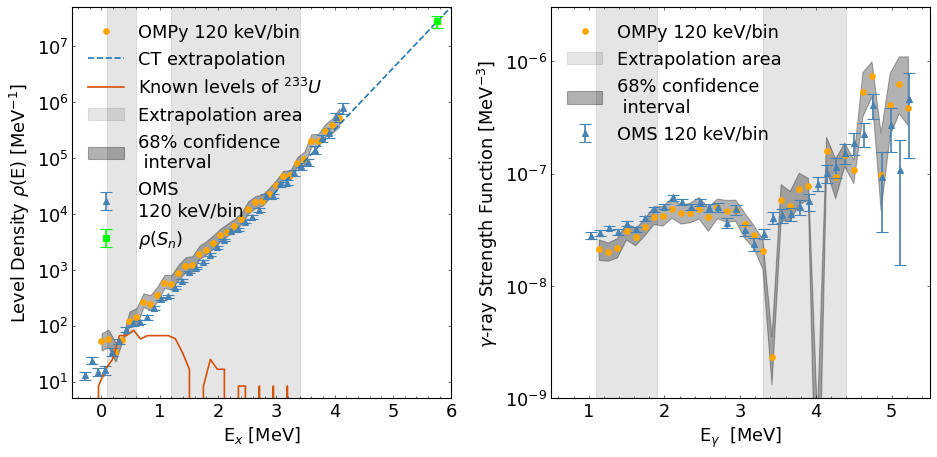

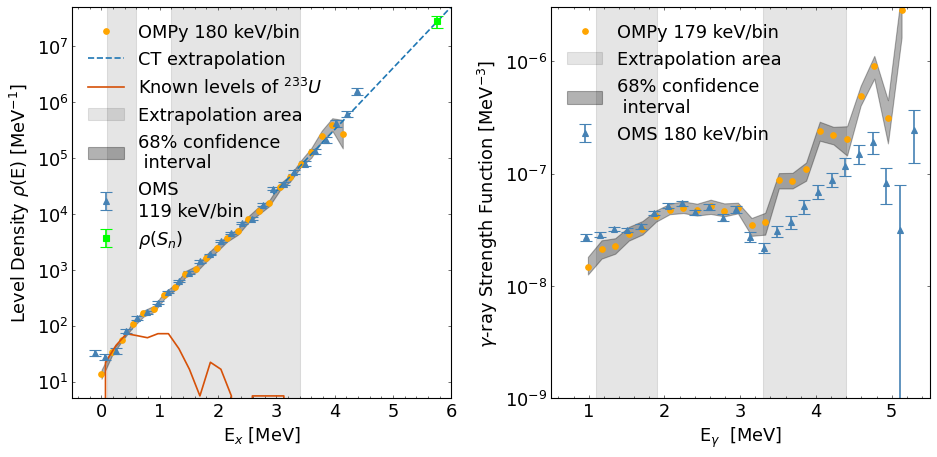

In [9]:
def plot_OMPy_vs_OMS(datetime, OMS_path):
    plt.rcParams["figure.figsize"] = (12,6)
    fig, (ax_nld, ax_gsf) = plt.subplots(1,2)
    fig.tight_layout()
    plot_nld_OMPy_vs_OMS(datetime, OMS_path, ax_nld)
    plot_gsf_OMPy_vs_OMS(datetime, OMS_path, ax_gsf)
    #plt.rcParams["figure.figsize"] = (10,10)
    

for i in range(len(datetimes)):
    datetime = datetimes[i]
    OMS_path = OMS_paths[i]
    plot_OMPy_vs_OMS(datetime, OMS_path)


"Does_it_work.cpp" 

Script to check the quality of the extracted
level density and strength function
by plotting exp. and calculated f.g. spectra
written by: ACL. June 7, 2012
Translated to Python 2021 (tellefs)

In [10]:
def read_rsg(filename):
    infile = open(filename, 'r')
    matrix = []
    
    #extract calibration parameters:
    count = 0
    for line in infile:
        values = line.split()
        if not(values):
            count +=1
            continue
        elif line.startswith('!CALIBRATION'):
            values = line.split(',')
            x_cal = values[1:4]
            y_cal = values[4:7]
            for i in range(len(x_cal)):
                x_cal[i] = float(x_cal[i])*1e-3 #convert to float, convert from keV to MeV
                y_cal[i] = float(y_cal[i])*1e-3
            count+=1
        elif line.startswith('!DIMENSION'):
            values = line.split(':')
            x_dim = int(values[1].split(',')[0])
            y_dim = int(values[2])
            count+=1
        elif line.startswith('!'):
            count +=1
            continue
        else:
            for i in range(len(values)):
                values[i] = float(values[i])
            matrix.append(values)
            count +=1
            
    matrix = om.Matrix(matrix)
    
    infile.close()
    return matrix, x_cal, y_cal, x_dim, y_dim

fg_exp, x_cal_exp, y_cal_exp, x_dim_exp, y_dim_exp= read_rsg(fg_exp_file)
fg_exp_error, x_cal_exp_error, y_cal_exp_error, x_dim_exp_error, y_dim_exp_error = read_rsg(fg_exp_err_file)
fg_theo, x_cal_theo, y_cal_theo, x_dim_theo, y_dim_theo = read_rsg(fg_theo_file)

bin1, bin2, bin3, bin4, bin5, bin6 = 13, 14, 15, 16, 17, 18

bins = [45, 47, 50, 53, 55, 59,]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(len(bins)):
    bin_no = bins[i]
    fg_theo_copy = fg_theo.copy()
    fg_theo_copy.cut('Ex', bin_no, bin_no+2)
    fg_theo_copy.Eg = x_cal_theo[0] + x_cal_theo[1]*fg_theo_copy.Eg + x_cal_theo[2]*fg_theo_copy.Eg**2
    fg_theo_copy.Ex = y_cal_theo[0] + y_cal_theo[1]*fg_theo_copy.Ex + y_cal_theo[2]*fg_theo_copy.Ex**2
    theo_y, theo_x = fg_theo_copy.projection('Eg')
    
    
    fg_exp_copy = fg_exp.copy()
    fg_exp_copy.cut('Ex', bin_no, bin_no+2)
    fg_exp_copy.Eg = x_cal_exp[0] + x_cal_exp[1]*fg_exp_copy.Eg + x_cal_exp[2]*fg_exp_copy.Eg**2
    fg_exp_copy.Ex = y_cal_exp[0] + y_cal_exp[1]*fg_exp_copy.Ex + y_cal_exp[2]*fg_exp_copy.Ex**2
    exp_y, exp_x = fg_exp_copy.projection('Eg');
    
    fg_exp_error_copy = fg_exp_error.copy()
    fg_exp_error_copy.cut('Ex', bin_no, bin_no+2)
    fg_exp_error_copy.Eg = x_cal_exp_error[0] + x_cal_exp_error[1]*fg_exp_error_copy.Eg + x_cal_exp_error[2]*fg_exp_error_copy.Eg**2
    fg_exp_error_copy.Ex = y_cal_exp_error[0] + y_cal_exp_error[1]*fg_exp_copy.Ex + y_cal_exp_error[2]*fg_exp_error_copy.Ex**2
    exp_err_y, exp_err_x = fg_exp_error_copy.projection('Eg');
    
    #cut arrays to show lesser points
    theo_y = theo_y[0:-1:3]
    theo_x = theo_x[0:-1:3]
    exp_y = exp_y[0:-1:3]
    exp_x = exp_x[0:-1:3]
    exp_err_y = exp_err_y[0:-1:3]
    exp_err_x = exp_err_x[0:-1:3]
    
    current_Ex = y_cal_theo[0] + y_cal_theo[1]*(bin_no+0.5) + y_cal_theo[2]*(bin_no+0.5)**2
    axes[i].step(theo_x, theo_y, where='mid', label='Ex = %.2f MeV'%current_Ex)
    
    
    axes[i].errorbar(exp_x, exp_y, yerr=exp_err_y, marker='^', linestyle='')
    axes[i].legend(fontsize=15)
    
    
    
    axes[i].set_xlim(0, 9)
    axes[i].set_ylim(0, 0.2)
    
fig.show()


#reset rcParams
#plt.rcParams["figure.figsize"] = (10,8)
#plt.rcParams['font.size'] = 25

NameError: name 'fg_exp_file' is not defined